<a href="https://colab.research.google.com/github/hanghae-plus-AI/AI-1-hyeondata/blob/main/Chapter2_1_%EA%B8%B0%EB%B3%B8%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DistilBERT fine-tuning으로 감정 분석 모델 학습하기

이번 실습에서는 pre-trained된 DistilBERT를 불러와 이전 주차 실습에서 사용하던 감정 분석 문제에 적용합니다. 먼저 필요한 library들을 불러옵니다.

In [ ]:
%pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

Note: you may need to restart the kernel to use updated packages.


그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

Using cache found in C:\Users\codeKim/.cache\torch\hub\huggingface_pytorch-transformers_main
c:\Users\codeKim\miniconda3\envs\kaggle\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


DistilBERT의 tokenizer를 불러왔으면 이제 `collate_fn`과 data loader를 정의합니다. 이 과정은 이전 실습과 동일하게 다음과 같이 구현할 수 있습니다.

## AG_News dataset 준비
    - Huggingface dataset의 `fancyzhx/ag_news`를 load합니다.
    - `collate_fn` 함수에 다음 수정사항들을 반영하면 됩니다.
        - Truncation과 관련된 부분들을 지웁니다.

In [ ]:
ds = load_dataset("fancyzhx/ag_news") # Huggingface dataset의 `fancyzhx/ag_news`를 load하는 코드


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True).input_ids) #Truncation과 관련된 부분 제거
  # texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

# Classifier output, loss function, accuracy function 변경
    - 뉴스 기사 분류 문제는 binary classification이 아닌 일반적인 classification 문제입니다. MNIST 과제에서 했던 것 처럼 `nn.CrossEntropyLoss` 를 추가하고 `TextClassifier`의 출력 차원을 잘 조정하여 task를 풀 수 있도록 수정하시면 됩니다.
    - 그리고 정확도를 재는 `accuracy` 함수도 classification에 맞춰 수정하시면 됩니다.

### 출력이 몇개 있는지 알기 위해서 최대 값과, 최솟 값 label확인

In [ ]:
print(max(ds["test"]['label']))
print(min(ds["test"]['label']))

3
0


이제 pre-trained DistilBERT를 불러옵니다. 이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [ ]:
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in C:\Users\codeKim/.cache\torch\hub\huggingface_pytorch-transformers_main
c:\Users\codeKim\miniconda3\envs\kaggle\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

출력 결과를 통해 우리는 DistilBERT의 architecture는 일반적인 Transformer와 동일한 것을 알 수 있습니다.
Embedding layer로 시작해서 여러 layer의 Attention, FFN를 거칩니다.

이제 DistilBERT를 거치고 난 `[CLS]` token의 representation을 가지고 text 분류를 하는 모델을 구현합시다.

### 출력 차원 조절

In [ ]:
from torch import nn


class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
    self.classifier = nn.Linear(768, 4)

  def forward(self, x):
    x = self.encoder(x)['last_hidden_state']
    x = self.classifier(x[:, 0])

    return x


model = TextClassifier()

Using cache found in C:\Users\codeKim/.cache\torch\hub\huggingface_pytorch-transformers_main
c:\Users\codeKim\miniconda3\envs\kaggle\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


위와 같이 `TextClassifier`의 `encoder`를 불러온 DistilBERT, 그리고 `classifier`를 linear layer로 설정합니다.
그리고 `forward` 함수에서 순차적으로 사용하여 예측 결과를 반환합니다.

다음은 마지막 classifier layer를 제외한 나머지 부분을 freeze하는 코드를 구현합니다.

In [ ]:
for param in model.encoder.parameters():
  param.requires_grad = False

위의 코드는 `encoder`에 해당하는 parameter들의 `requires_grad`를 `False`로 설정하는 모습입니다.
`requires_grad`를 `False`로 두는 경우, gradient 계산 및 업데이트가 이루어지지 않아 결과적으로 학습이 되지 않습니다.
즉, 마지막 `classifier`에 해당하는 linear layer만 학습이 이루어집니다.
이런 식으로 특정 부분들을 freeze하게 되면 효율적으로 학습을 할 수 있습니다.

마지막으로 이전과 같은 코드를 사용하여 학습 결과를 확인해봅시다.

### 출력 차원 조절에 따른 accuracy 함수 수정

In [ ]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  with torch.no_grad():
    model.eval()
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)
      preds = torch.argmax(preds, dim=-1)
      # preds = (preds > 0).long()[..., 0]

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item()

  return acc / cnt



## nn.CrossEntropyLoss로 변경

In [ ]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

train_acc_list = []
test_acc_list = []

lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCEWithLogitsLoss()


optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)  #nn.CrossEntropyLoss()으로 변경에 따른 수정
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_acc_list.append(accuracy(model, train_loader))
  test_acc_list.append(accuracy(model, test_loader))


  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch   0 | Train Loss: 888.5515608787537
Epoch   1 | Train Loss: 699.0446733534336
Epoch   2 | Train Loss: 672.535823918879
Epoch   3 | Train Loss: 656.2747274115682
Epoch   4 | Train Loss: 652.4208410605788
Epoch   5 | Train Loss: 646.1950311660767
Epoch   6 | Train Loss: 641.2127779498696
Epoch   7 | Train Loss: 637.7196315377951
Epoch   8 | Train Loss: 637.1767690107226
Epoch   9 | Train Loss: 632.4191472008824


# 학습 결과 Report

### epoch 마다 train, test의 정확도를 보여주는 plot 입니다.

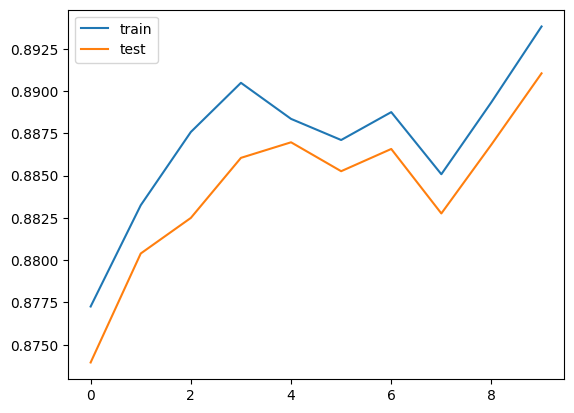

In [ ]:
import matplotlib.pyplot as plt

def plot_acc(trainloader_acc, testloader_acc, label1='train', label2='test'):
  x = np.arange(len(trainloader_acc))

  plt.plot(x, trainloader_acc, label=label1)
  plt.plot(x, testloader_acc, label=label2)
  plt.legend()
  plt.show()

# plot하는 함수 사용
plot_acc(train_acc_list, test_acc_list)

위의 plot을 보면 train과 test가 정확도가 비슷하게 가고 있는 것을 알 수 있으면서, 중간에 정확도가 떨어지긴 했지만 마지막에는 제일 정확도가 높은 것을 알 수 있다.

## 최종 모델의 train과 test의 정확도 입니다.

In [ ]:
with torch.no_grad():
  model.eval()
  train_acc = accuracy(model, train_loader)
  test_acc = accuracy(model, test_loader)
  print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

=========> Train acc: 0.894 | Test acc: 0.891
